In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as kb
import os
import time
import wandb
import sys
import random as rd
import tensorflow_probability as tfp

sys.path.append("..")

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import PerturbedPendulum_Methods as pp

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

### $$\textbf{model} \equiv R \circ A_{1} \circ A_{2} \circ A_{3} \circ A_{4} \circ R \circ A_{4}^{-1} \circ A_{3}^{-1} \circ A_{2}^{-1} \circ A_{1}^{-1} $$

In [64]:
class R(tf.keras.layers.Layer):

    def __init__(self):
        super(R, self).__init__()
        
    def call(self, inputs):
        return inputs*tf.constant([[1., -1.]])

In [65]:
class simple_fn(layers.Layer):
    def __call__(self, x):
        return tf.tanh(x), tf.tanh(x)

In [82]:
class RealNVP(tf.keras.Model):
    
    def __init__(self):
        
            super(RealNVP, self).__init__()
        
            self.R = R()
            
            self.A1 = tfp.bijectors.RealNVP(num_masked=-1, shift_and_log_scale_fn=tfp.bijectors.real_nvp_default_template(hidden_layers=[512, 512]))
            self.A2 = tfp.bijectors.RealNVP(num_masked=1, shift_and_log_scale_fn=tfp.bijectors.real_nvp_default_template(hidden_layers=[512, 512]))
            self.A3 = tfp.bijectors.RealNVP(num_masked=-1, shift_and_log_scale_fn=tfp.bijectors.real_nvp_default_template(hidden_layers=[512, 512]))
            self.A4 = tfp.bijectors.RealNVP(num_masked=-1, shift_and_log_scale_fn=tfp.bijectors.real_nvp_default_template(hidden_layers=[512, 512]))
            self.A5 = tfp.bijectors.RealNVP(num_masked=1, shift_and_log_scale_fn=tfp.bijectors.real_nvp_default_template(hidden_layers=[512, 512]))
            self.A6 = tfp.bijectors.RealNVP(num_masked=-1, shift_and_log_scale_fn=tfp.bijectors.real_nvp_default_template(hidden_layers=[512, 512]))
            self.A7 = tfp.bijectors.RealNVP(num_masked=1, shift_and_log_scale_fn=tfp.bijectors.real_nvp_default_template(hidden_layers=[512, 512]))

    def call(self, input_tensor, training=False):
        
            ###########
            
            #A = self.R(input_tensor)
            
            A = self.A1(input_tensor)
            A = self.A2(A)
            A = self.A3(A)
            A = self.A4(A)
            A = self.A5(A)
            A = self.A6(A)
            A = self.A7(A)
            
            #A = self.R(A)

            A = self.A7.inverse(A)
            A = self.A6.inverse(A)
            A = self.A5.inverse(A)
            A = self.A4.inverse(A)
            A = self.A3.inverse(A)
            A = self.A2.inverse(A)
            A = self.A1.inverse(A)
            
            
            return A #out, out_a #, out_b

In [83]:
file = open("x_train.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()

x = []
y = []

read_x = open("x_train.txt", "r")
read_y = open("y_train.txt", "r")
read_z = open("z_train.txt", "r")

for i in range(int(line_count)):

    x.append([float(read_x.readline()), float(read_y.readline()), float(read_z.readline())])

read_x.close()
read_y.close()
read_z.close()

print("Number of points: ", len(x))

Number of points:  20001


In [86]:
x = []
y = []
for i in range(4000):
    
    i,j = rd.random() + 1., rd.random() + 1. 
    x.append([i,j])
    y.append([3*np.sin(i), 2*np.sin(j)])


In [85]:
x_train = x[0:-1]
y_train = x[1:]

x_train = np.array(x)
x_train = x_train.astype(np.float32)

y_train = np.array(y)
y_train = y_train.astype(np.float32)

a_train = np.array(np.shape(x_train))
a_train = a_train.astype(np.float32)

#x_val = x_train[-val_len:]
#y_val = y_train[-val_len:]

#x_train = x_train[:-val_len]
#y_train = y_train[:-val_len]

#val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
#val_dataset = val_dataset.batch(val_batch)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(10000)

In [87]:
model = RealNVP()

In [70]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #loss = custom_loss,
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=keras.optimizers.Adam(0.001), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [71]:
history = model.fit(x_train, y_train, validation_split=0.1, batch_size = 1000, epochs = 100, verbose=1) #np.array(x), [np.array(y),a,a]

Epoch 1/100
4/4 [==============================] - 2s 163ms/step - loss: 1.3447 - accuracy: 0.3008 - val_loss: 1.3417 - val_accuracy: 0.3250
Epoch 2/100
4/4 [==============================] - 0s 29ms/step - loss: 1.3447 - accuracy: 0.3008 - val_loss: 1.3417 - val_accuracy: 0.3250
Epoch 3/100
4/4 [==============================] - 0s 30ms/step - loss: 1.3447 - accuracy: 0.3008 - val_loss: 1.3417 - val_accuracy: 0.3250
Epoch 4/100
4/4 [==============================] - 0s 30ms/step - loss: 1.3447 - accuracy: 0.3008 - val_loss: 1.3417 - val_accuracy: 0.3250
Epoch 5/100
4/4 [==============================] - 0s 29ms/step - loss: 1.3447 - accuracy: 0.3008 - val_loss: 1.3417 - val_accuracy: 0.3250
Epoch 6/100
4/4 [==============================] - 0s 30ms/step - loss: 1.3447 - accuracy: 0.3008 - val_loss: 1.3417 - val_accuracy: 0.3250
Epoch 7/100
4/4 [==============================] - 0s 30ms/step - loss: 1.3447 - accuracy: 0.3008 - val_loss: 1.3417 - val_accuracy: 0.3250
Epoch 8/100
4/4 [==

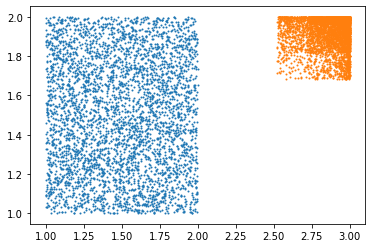

In [50]:
plt.scatter([i[0] for i in x], [i[1] for i in x], s = 1)
plt.scatter([i[0] for i in y], [i[1] for i in y], s = 1)

In [88]:
model(np.array(x))

<tf.Tensor: shape=(4000, 2), dtype=float32, numpy=
array([[1.8621082, 1.7838857],
       [1.9320009, 1.1672055],
       [1.4229366, 1.816755 ],
       ...,
       [1.8575358, 1.9118116],
       [1.1172385, 1.6207154],
       [1.3852568, 1.3441159]], dtype=float32)>

In [89]:
x

[[1.8621081854027983, 1.7838857180017218],
 [1.9320008625261793, 1.167205410236411],
 [1.4229365096188893, 1.8167550964171488],
 [1.065632166445448, 1.1656133201949896],
 [1.0690189857447798, 1.521790519751809],
 [1.7567463891989334, 1.6495934597302906],
 [1.4221275327373184, 1.4909986419697667],
 [1.7994686398545823, 1.9805923637427958],
 [1.618099769268182, 1.6297215422290803],
 [1.514142099870798, 1.6809754163235158],
 [1.397911917025557, 1.7325634334217166],
 [1.6303076047274634, 1.1153595002174308],
 [1.8270195810352508, 1.4965760169255424],
 [1.675232809545205, 1.4819036783582953],
 [1.211298181207205, 1.8821545648308458],
 [1.5078983351070945, 1.8584939179750561],
 [1.7863281822250028, 1.9218448210979617],
 [1.4461972392181828, 1.0794887938776485],
 [1.1084093534184465, 1.9641918982286373],
 [1.378077183972876, 1.314020167843068],
 [1.8249500986466716, 1.620804397579715],
 [1.3494974021995558, 1.7855772796761724],
 [1.9093408163012822, 1.4027597172689013],
 [1.4866753422265386, 